In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
import datetime

### Load Dataset

In [2]:
data = pd.read_csv('이더리움.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,26-May-21,"$2,707.05","$2,911.74","$2,652.09","$2,888.70","$42,499,766,020","$335,196,485,646"
1,27-May-21,"$2,888.75","$2,888.75","$2,642.61","$2,736.49","$33,373,635,283","$317,571,010,585"
2,28-May-21,"$2,742.47","$2,761.36","$2,336.36","$2,419.91","$39,999,114,805","$280,864,129,343"
3,29-May-21,"$2,414.07","$2,566.94","$2,208.49","$2,279.51","$33,773,720,220","$264,600,384,052"
4,30-May-21,"$2,278.29","$2,472.19","$2,188.83","$2,390.31","$25,876,619,428","$277,492,990,927"


### Compute Mid Price

In [3]:
high_prices = data['High'].values
low_prices = data['Low'].values
#mid_prices = (high_prices + low_prices)/2

high_price_list = []
low_price_list = []

for i in high_prices:
    i = i.replace(',','')
    i = float(i.replace('$',''))
    high_price_list.append(i)
high_prices = np.array(high_price_list)

for i in low_prices:
    i = i.replace(',','')
    i = float(i.replace('$',''))
    low_price_list.append(i)
low_prices = np.array(low_price_list)

mid_prices = (high_prices + low_prices)/2

### Create Windows

In [4]:
seq_len = 50 # 윈도우 사이즈 최근 50일보고 한개를 예측한다. 51개씩저장해야한다.
sequence_length = seq_len + 1 # 51개 저장.

result = []
for index in range(len(mid_prices)-sequence_length):
    result.append(mid_prices[index:index + sequence_length])

### Normalize Data

In [5]:
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0]))-1)for p in window]
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0]*0.9)) # 90퍼센트 트레이닝셋.
train = result[:row,:]
np.random.shuffle(train) # 트레이닝셋 순서 랜덤으로 셔플

x_train = train[:, :-1]
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
y_test = result[row:, -1]

x_train.shape, x_test.shape # 1057개?

((284, 50, 1), (31, 50, 1))

### Build a Model

In [6]:
m = Sequential()
m.add(LSTM(50,return_sequences=True,input_shape=(50,1)))
m.add(LSTM(64,return_sequences=False))
m.add(Dense(1,activation='linear'))
m.compile(loss='mse',optimizer='rmsprop')
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


### Training

In [7]:
m.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=20)

Epoch 1/20
29/29 [==============================] - 3s 41ms/step - loss: 0.0162 - val_loss: 0.0095
Epoch 2/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 3/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 4/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0066 - val_loss: 0.0078
Epoch 5/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 6/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 7/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0051 - val_loss: 0.0065
Epoch 8/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 9/20
29/29 [==============================] - 1s 23ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 10/20
29/29 [==============================] - 1s 22ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 11/

### Prediction

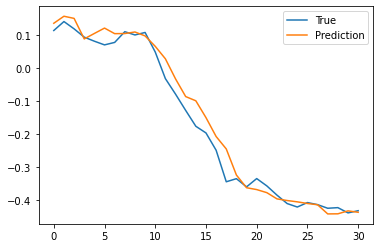

In [8]:
pred = m.predict(x_test)
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()
# 파랑색 - 실제데이터
# 주황색 - 예측데이터